In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import pandas as pd
import sys
import os
sys.path.insert(1, '../../PENTrackAnalysis/')
import ParticlePlottingFunctions as ppf

### For data from the df file
* x,y,z are in cm
* B_i is in mT

Coordinate center is not know yet, but data was aquired from Takashi's 2019 mapping and processed using:
```
df_all['x'] = - df_all.u + 10.25
df_all['y'] = -df_all.w
df_all['z'] = df_all.v -1.25 +188.1 -275 #-> sets z = 0 to the center of the MSR 
# -1.25cm accounts for the position of the sensing center of the probe and the marker on the probe. 
# + 188.1cm: from z=0 of the measurement to the floor, -275cm: from the floor to the planned center of MSR
# df_all['z'] = df_all.v -1.25 ## previous version
```
so
z = 0 is at what ever the planed center of the MSR was at the time   
X and Y are swapped compared to what is in PENTrack - nope they aren't actually swapped, but quite rotated. In PENTrack the guides near the SCM are along x, where as for the mapping the path of the guides into the MSR is along y.

<img src="./Fig12.2_CDR2020_layout.jpg" width="500" />
<img src="./floorPlanMap2019.png" width="500" />

In [ ]:
x_off = 0 # cm
y_off = -100 # cm
z_off = 0 # cm

In [26]:
# file = "data_export/map_interpXcut50_[-141.8,98.2]_[-327.2,192.8]_[-180.0,250.0].csv"
file = "data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv"

In [116]:
df_BField_data = pd.read_csv(file, comment='#')

Bx_dense = df_BField_data["B_x"]
By_dense = df_BField_data["B_y"]
Bz_dense = df_BField_data["B_z"]

x_dense = df_BField_data["x"] + x_off
y_dense = df_BField_data["y"] + y_off
z_dense = df_BField_data["z"] + z_off

In [119]:
# centerP = df_BField_data["x" == 0] 
top_balc_M11 = [max(df_BField_data["x"]), max(df_BField_data["y"]), max(df_BField_data["z"])]
top_balc_cycl = [min(df_BField_data["x"]), max(df_BField_data["y"]), max(df_BField_data["z"])]
top_cycl_UCN = [min(df_BField_data["x"]), min(df_BField_data["y"]), max(df_BField_data["z"])]
top_M11_UCN = [max(df_BField_data["x"]), min(df_BField_data["y"]), max(df_BField_data["z"])]

bottom_balc_M11 = [max(df_BField_data["x"]), max(df_BField_data["y"]), min(df_BField_data["z"])]
bottom_balc_cycl = [min(df_BField_data["x"]), max(df_BField_data["y"]), min(df_BField_data["z"])]
bottom_cycl_UCN = [min(df_BField_data["x"]), min(df_BField_data["y"]), min(df_BField_data["z"])]
bottom_M11_UCN = [max(df_BField_data["x"]), min(df_BField_data["y"]), min(df_BField_data["z"])]


corners = np.array([top_balc_M11, top_balc_cycl, top_cycl_UCN, top_M11_UCN, bottom_balc_M11, 
           bottom_balc_cycl, bottom_cycl_UCN, bottom_M11_UCN]).T /100
center = np.array([x_off,y_off,z_off]) 
# print(corners)

print(f"Max dimension in x: {np.abs(top_balc_cycl[0]-top_balc_M11[0])} , y:", 
      f"{(top_balc_cycl[1]-top_cycl_UCN[1])}, z: {(top_balc_M11[2]-bottom_balc_M11[2])} cm")

Max dimension in x: 240.0 , y: 520.0, z: 348.50000000000006 cm


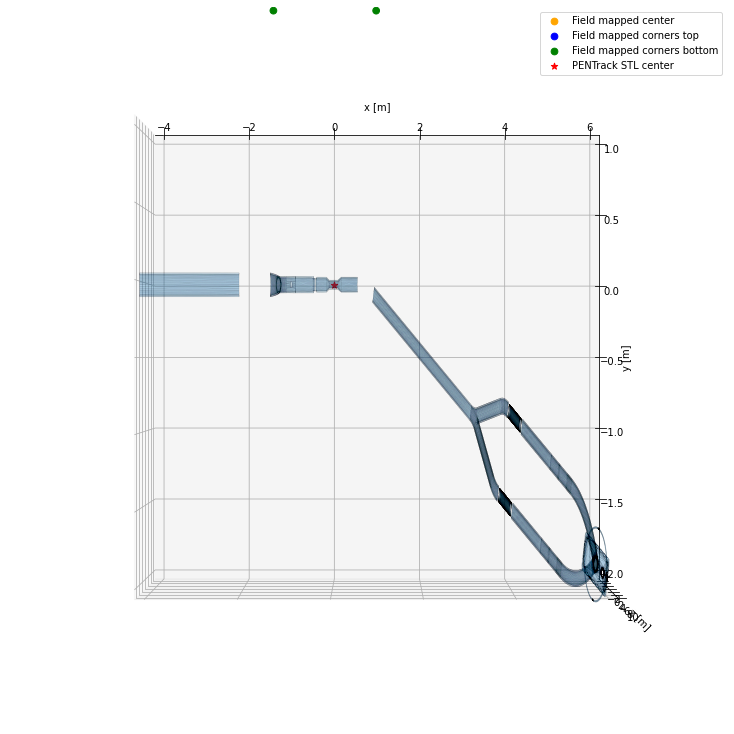

In [126]:
###### plt.rcParams['font.size'] = '22'
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# axes.set_title("Electric Field for bias of 800 V", pad=-10)
# plt.title("2019 Magnetic field mapping", pad=-10)

axes.scatter(center[0], center[0], center[0], color='orange', s=45, label="Field mapped center")
axes.scatter(corners[0,:4], corners[1,:4], corners[2,:4], color='blue', s=45, label="Field mapped corners top")
axes.scatter(corners[0,4:], corners[1,4:], corners[2,4:], color='green', s=45, label="Field mapped corners bottom")

#loads all the file I have in this folder as STLs
STLpath = '../../PENTrackAnalysis/STLsToGraph'
stl_array = os.listdir(STLpath)

for STLfile in stl_array:
#     print(STLfile)
    ppf.graphSTL(STLpath+'/'+STLfile, axes)
    
axes.scatter(0, 0, 0, color='red', marker='*', s=45, label="PENTrack STL center")
    
# axes.view_init(elev=10., azim=45)
axes.view_init(elev=90., azim=-90)

axes.set_xlim(-4, 6)
axes.set_ylim(-2, 1)
# axes.set_zlim(-0.6, 0.6)
axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')
axes.legend()

plt.show()

## Reformating of B files for PENTrack

In [111]:
def FixOffset(BField_data):
#     x_off = 0 # cm
#     y_off = -100 # cm
#     z_off = 0 # cm
    off_sets = np.array([x_off, y_off, z_off])
    # numpy.ndarray.copy

    BField_data2 = BField_data.copy()
    BField_data2[1:4] = BField_data2[1:4] + off_sets[:,None]
    return BField_data2, off_sets

In [112]:
from datetime import date
file = "data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv"
BField_Names = np.genfromtxt(file, delimiter=',', names=True).dtype.names[1:]

BField_data = np.genfromtxt(file, delimiter=',', skip_header=1).T

BField_data, off_sets = FixOffset(BField_data)

BField_data = BField_data[1:].T #remove the first line of indexes

In [115]:
# len(BField_data[0]) #check units again
comment = "This data, interpolated from Takashi's summer 2019 data is not position referenced properly,"+\
    " as the origin is currently not the same as that used in the PENTrack STL files."
headerText = f'File: {file}\n' + f'Date created: {date.today().strftime("%d/%m/%Y")}\n'\
    + 'Units: [cm], [mT]\n' +f'Offset from original data used: {off_sets} cm\n' + f'Comments: {comment}\n'\
    + '\t'.join(BField_Names)
print(headerText)

File: data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv
Date created: 05/08/2022
Units: [cm], [mT]
Offset from original data used: [10.  40.4 25. ] cm
Comments: This data, interpolated from Takashi's summer 2019 data is not position referenced properly, as the origin is currently not the same as that used in the PENTrack STL files.
x	y	z	B_x	B_y	B_z


In [110]:
# BField_Names
np.savetxt('./data_export/map_interp50_notRef.txt', BField_data,  delimiter='\t', newline='\n', header=headerText)